# **Exploring the Sentiment of Financial News between 2009-2020**


In [1]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.9 MB/s eta 0:00:00


In [2]:
#useful packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import yfinance as yf
from datetime import datetime, date
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.colab import files

import warnings
warnings.filterwarnings("ignore")

## **Data pre-processing**

We will be using data for Daily Financial News for 6000+ Stocks from Kaggle.

link : https://www.kaggle.com/datasets/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests?fbclid=IwAR3frLS0VMqpkULXuKkTkk8XHCC-xbbpvEbavMsTcG2bf1SSi8yq8U8Ag5Y

We will be using the file analyst_ratings_processed.csv since the data was already processed. The difference between this and raw_analyst_headlines is that this has exact dates to the minute vs. raw_analyst_ratings which is only the day without hour or minutes. Timezone is UTC-4. 

In [3]:
start_date = datetime(2012, 1, 1)
end_date = datetime(2020, 12, 31)

In [15]:
analyst_ratings_processed = pd.read_csv('analyst_ratings_processed.csv',index_col=0)
analyst_ratings_processed

title  \
0.0                  Stocks That Hit 52-Week Highs On Friday   
1.0               Stocks That Hit 52-Week Highs On Wednesday   
2.0                            71 Biggest Movers From Friday   
3.0             46 Stocks Moving In Friday's Mid-Day Session   
4.0        B of A Securities Maintains Neutral on Agilent...   
...                                                      ...   
1413844.0             Top Narrow Based Indexes For August 29   
1413845.0  Recap: Wednesday's Top Percentage Gainers and ...   
1413846.0  UPDATE: Oppenheimer Color on China Zenix Auto ...   
1413847.0  Oppenheimer Initiates China Zenix At Outperfor...   
1413848.0  China Zenix Auto International Opens For Tradi...   

                                date stock  
0.0        2020-06-05 10:30:00-04:00     A  
1.0        2020-06-03 10:45:00-04:00     A  
2.0        2020-05-26 04:30:00-04:00     A  
3.0        2020-05-22 12:45:00-04:00     A  
4.0        2020-05-22 11:38:00-04:00     A  
...                              ...   ...  
1413844.0  2011-08-29 10:41:00-04:00    ZX  
1413845.0  2011-06-22 16:44:00-04:00    ZX  
1413846.0  2011-06-21 08:26:00-04:00    ZX  
1413847.0  2011-06-21 05:59:00-04:00    ZX  
1413848.0  2011-05-12 09:36:00-04:00    ZX  

[1400469 rows x 3 columns]

In [16]:
analyst_ratings_processed = analyst_ratings_processed.reset_index(drop=True)

analyst_ratings_processed['title'] = analyst_ratings_processed['title'].str.strip()
analyst_ratings_processed['date']  = analyst_ratings_processed['date'].str.strip()
analyst_ratings_processed['stock'] = analyst_ratings_processed['stock'].str.strip()

analyst_ratings_processed.dropna(inplace=True)

analyst_ratings_processed['date'] = analyst_ratings_processed['date'].apply(lambda x: datetime.strptime(x[:10],'%Y-%m-%d'))
analyst_ratings_processed = analyst_ratings_processed.sort_values('date').reset_index(drop=True)
analyst_ratings_processed = analyst_ratings_processed[(analyst_ratings_processed['date']>=start_date)&(analyst_ratings_processed['date']<=end_date)].reset_index(drop=True)

In [19]:
tickers = [
    "^DJI", "^GSPC", "^NDX", "^FTSE", "^N225",
    "GOOGL", "AAPL", "FB", "AMZN", "MSFT",
    "TWTR", "NOK", "PHG", "SIEGY", "BIDU",
    "BABA", "TCEHY", "SONY", "JPM", "HSBC",
    "CICHY", "XOM", "RDS-A", "RDS-B", "PTR",
    "TSLA", "VWAGY", "TM", "KO", "BUD", "KNBWY"
]
analyst_ratings_processed[analyst_ratings_processed['stock'].isin(tickers)].groupby('stock').nunique().sort_values('date',ascending=False)

title  date
stock             
KO      2149  1098
BABA    2753  1072
BIDU    1765   959
TM      1404   869
NOK     1531   809
BUD     1009   626
GOOGL   1560   474
XOM      574   303
TSLA    1882   291
HSBC     376   281
PHG      327   232
PTR      234   201
AAPL     463    86
FB       380    86
AMZN     326    41
JPM       10     9
TWTR      10     5

In [20]:
stock = 'KO'
data = analyst_ratings_processed[analyst_ratings_processed['stock'] == stock][['date','title']]
data

date                                              title
1374    2012-01-05        SODA Pops as Kraft gets Busy with the Fizzy
2228    2012-01-09  Geaux Tigers/ Roll Tide: Four Stocks For The B...
3277    2012-01-11        UBS Downgrades Coca-Cola Company to Neutral
3278    2012-01-11  Squeezed Oranges: Orange Juice Futures Rising ...
3924    2012-01-12             Is Coke's Secret Ingredient Fungicide?
...            ...                                                ...
1155448 2020-05-15  Coca-Cola CFO Says Trough Will Come In Q2, Say...
1157798 2020-05-20  Coca-Cola shares are trading higher, potential...
1160587 2020-05-26  Shares of several consumer staples are trading...
1167824 2020-06-08  Morgan Stanley Maintains Equal-Weight on Coca-...
1170075 2020-06-11  Shares of several companies in the broader con...

[2203 rows x 2 columns]

## **NLP Model: FinBert**
FinBERT is a pre-trained NLP model based on BERT, Google's revolutionary transformer model. Simply put: FinBERT is just a version of BERT trained on financial data (hence the "Fin" part of its name), specifically for sentiment analysis. 

BERT is a general language model. Financial news and stock reports often involve a lot of domain-specific jargon (there's plenty in the Table above, in fact), so a  model like BERT can't generalize well in this domain. 


In [21]:
headlines = data['title'].to_list()
dates = data['date'].tolist()

In [22]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [23]:
#Model classes
model.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [ ]:
inputs = tokenizer(headlines, padding = True, truncation = True, return_tensors='pt')

In [ ]:
outputs = model(**inputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

In [24]:
positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

table = {'Date': dates,
        'Headline':headlines,
        "Positive":positive,
        "Negative":negative, 
        "Neutral":neutral}
      
scores = pd.DataFrame(table, columns = ['Date',"Headline", "Positive", "Negative", "Neutral"])
scores

Date                                           Headline  Positive  \
0    2012-01-05        SODA Pops as Kraft gets Busy with the Fizzy  0.088150   
1    2012-01-09  Geaux Tigers/ Roll Tide: Four Stocks For The B...  0.112618   
2    2012-01-11  Squeezed Oranges: Orange Juice Futures Rising ...  0.160256   
3    2012-01-11        UBS Downgrades Coca-Cola Company to Neutral  0.045641   
4    2012-01-12             Is Coke's Secret Ingredient Fungicide?  0.030254   
...         ...                                                ...       ...   
2198 2020-05-15  Coca-Cola CFO Says Trough Will Come In Q2, Say...  0.029711   
2199 2020-05-20  Coca-Cola shares are trading higher, potential...  0.955576   
2200 2020-05-26  Shares of several consumer staples are trading...  0.948266   
2201 2020-06-08  Morgan Stanley Maintains Equal-Weight on Coca-...  0.747651   
2202 2020-06-11  Shares of several companies in the broader con...  0.007754   

      Negative   Neutral  
0     0.152316  0.759534  
1     0.016020  0.871361  
2     0.801383  0.038361  
3     0.727975  0.226384  
4     0.050230  0.919515  
...        ...       ...  
2198  0.902083  0.068206  
2199  0.021397  0.023027  
2200  0.027365  0.024369  
2201  0.016480  0.235869  
2202  0.973434  0.018812  

[2203 rows x 5 columns]

We will create a sentiment score for each headline using the formula: 

**Sentiment Score = (Positive Probability - Negative Probability) * (1 - Neutral Probability)**

In [25]:
scores['Score'] = (scores['Positive'] - scores['Negative'])*(1 - scores['Neutral'])
scores = scores.groupby('Date',as_index=False).mean()
scores

Date  Positive  Negative   Neutral     Score
0    2012-01-05  0.088150  0.152316  0.759534 -0.015430
1    2012-01-09  0.112618  0.016020  0.871361  0.012426
2    2012-01-11  0.102948  0.764679  0.132373 -0.572199
3    2012-01-12  0.058401  0.033122  0.908478  0.002813
4    2012-01-24  0.072732  0.400347  0.526922 -0.154987
...         ...       ...       ...       ...       ...
1093 2020-05-15  0.029711  0.902083  0.068206 -0.812870
1094 2020-05-20  0.955576  0.021397  0.023027  0.912668
1095 2020-05-26  0.948266  0.027365  0.024369  0.898460
1096 2020-06-08  0.747651  0.016480  0.235869  0.558711
1097 2020-06-11  0.007754  0.973434  0.018812 -0.947514

[1098 rows x 5 columns]

# Create the returns dataset

In [9]:
stock_data = yf.download(stock, start=start_date, end=end_date)
stock_data['log_return'] = np.log(stock_data['Adj Close'] / stock_data['Adj Close'].shift(1))
stock_data.dropna(inplace=True)

stock_data = stock_data.reset_index()[['Date','log_return']]
stock_data

[*********************100%***********************]  1 of 1 completed


Date  log_return
0    2012-01-04   -0.006293
1    2012-01-05   -0.004746
2    2012-01-06   -0.006363
3    2012-01-09    0.000000
4    2012-01-10    0.005930
...         ...         ...
2258 2020-12-23    0.006047
2259 2020-12-24    0.006759
2260 2020-12-28    0.013383
2261 2020-12-29   -0.000554
2262 2020-12-30    0.005711

[2263 rows x 2 columns]

In [26]:
sentiment_return_data = stock_data.merge(scores[['Date','Score']],how='left',on='Date')
sentiment_return_data

Date  log_return     Score
0    2012-01-04   -0.006293       NaN
1    2012-01-05   -0.004746 -0.015430
2    2012-01-06   -0.006363       NaN
3    2012-01-09    0.000000  0.012426
4    2012-01-10    0.005930       NaN
...         ...         ...       ...
2258 2020-12-23    0.006047       NaN
2259 2020-12-24    0.006759       NaN
2260 2020-12-28    0.013383       NaN
2261 2020-12-29   -0.000554       NaN
2262 2020-12-30    0.005711       NaN

[2263 rows x 3 columns]

In [27]:
print(f"Number of missing days: {sentiment_return_data['Score'].isna().sum()}")

Number of missing days: 1254


In order to have a complete dataset with sentiment scores for every day, we will try two approaches:

1. **Fill missing days with the previous day:** This approach assumes that the sentiment from the previous day carries over to the next day if there's no headline for that day.

2. **Fill missing days with the average sentiment score:** This approach calculates the average sentiment score for the entire dataset and fills the missing days with this average value.

3. **Fill missing days with a neutral sentiment score:** This approach assumes that if there's no headline for a day, the sentiment score for that day is neutral.

In [28]:
sentiment_return_data_previous = sentiment_return_data.fillna(method='ffill')
sentiment_return_data_previous = sentiment_return_data_previous.rename(columns={'Score':'Score Previous Approach'})

average_sentiment_score = sentiment_return_data['Score'].mean()
sentiment_return_data_average = sentiment_return_data.fillna(average_sentiment_score)
sentiment_return_data_average = sentiment_return_data_average.rename(columns={'Score':'Score Average Approach'})

sentiment_return_data_neutral = sentiment_return_data.fillna(0)
sentiment_return_data_neutral = sentiment_return_data_neutral.rename(columns={'Score':'Score Neutral Approach'})

In [29]:
all_approaches = sentiment_return_data_previous.merge(sentiment_return_data_average,on=['Date', 'log_return']).merge(sentiment_return_data_neutral,on=['Date', 'log_return'])

In [30]:
all_approaches['next_day_log_return'] = all_approaches['log_return'].shift(-1)
all_approaches

Date  log_return  Score Previous Approach  Score Average Approach  \
0    2012-01-04   -0.006293                      NaN                0.039528   
1    2012-01-05   -0.004746                -0.015430               -0.015430   
2    2012-01-06   -0.006363                -0.015430                0.039528   
3    2012-01-09    0.000000                 0.012426                0.012426   
4    2012-01-10    0.005930                 0.012426                0.039528   
...         ...         ...                      ...                     ...   
2258 2020-12-23    0.006047                -0.947514                0.039528   
2259 2020-12-24    0.006759                -0.947514                0.039528   
2260 2020-12-28    0.013383                -0.947514                0.039528   
2261 2020-12-29   -0.000554                -0.947514                0.039528   
2262 2020-12-30    0.005711                -0.947514                0.039528   

      Score Neutral Approach  next_day_log_return  
0                   0.000000            -0.004746  
1                  -0.015430            -0.006363  
2                   0.000000             0.000000  
3                   0.012426             0.005930  
4                   0.000000            -0.018632  
...                      ...                  ...  
2258                0.000000             0.006759  
2259                0.000000             0.013383  
2260                0.000000            -0.000554  
2261                0.000000             0.005711  
2262                0.000000                  NaN  

[2263 rows x 6 columns]

In [31]:
all_approaches.to_csv('nlp_results.csv',index=False)
files.download('nlp_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

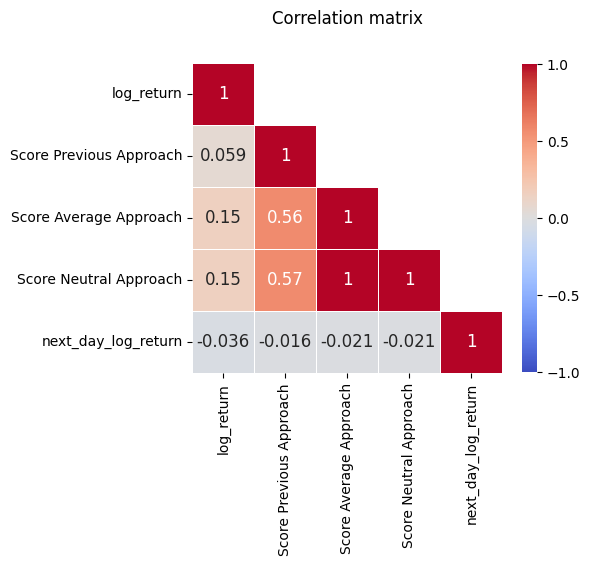

In [32]:
corr_matrix = all_approaches.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)]= True

f, ax = plt.subplots(figsize=(5, 5)) 
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .8, 
                                  'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
ax.set_title('Correlation matrix', y=1.1)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [33]:
sentiment_return_data_neutral.drop(columns='log_return').rename(columns={'Score Neutral Approach':'sentiment_analysis_score'}).to_csv('sentiment_analysis_results.csv',index=False)
files.download('sentiment_analysis_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>